In [7]:
import cv2
import numpy as np
import glob

# Chemin vers le dossier d'images
image_paths = glob.glob("pour_etudiants/LF*.jpg")
image_paths.sort()  # Trier les images par ordre

# Charger les deux premières images (F1 et F2)
F1 = cv2.imread(image_paths[1], cv2.IMREAD_GRAYSCALE)
F2 = cv2.imread(image_paths[2], cv2.IMREAD_GRAYSCALE)

# Calculer les dérivées spatiales et temporelles
Ix = cv2.Sobel(F1, cv2.CV_64F, 1, 0, ksize=5)  # Dérivée par rapport à x
Iy = cv2.Sobel(F1, cv2.CV_64F, 0, 1, ksize=5)  # Dérivée par rapport à y
It = F2 - F1  # Dérivée temporelle


In [8]:
def compute_optical_flow(Ix, Iy, It, window_size=5):
    flow = np.zeros((F1.shape[0], F1.shape[1], 2))
    half_window = window_size // 2

    for i in range(half_window, F1.shape[0] - half_window):
        for j in range(half_window, F1.shape[1] - half_window):
            # Extraire les patchs locaux
            Ix_patch = Ix[i-half_window:i+half_window+1, j-half_window:j+half_window+1].flatten()
            Iy_patch = Iy[i-half_window:i+half_window+1, j-half_window:j+half_window+1].flatten()
            It_patch = It[i-half_window:i+half_window+1, j-half_window:j+half_window+1].flatten()

            # Construire le système linéaire
            A = np.vstack((Ix_patch, Iy_patch)).T
            b = -It_patch

            # Résoudre pour le vecteur de flux optique
            if np.linalg.cond(A) < 1e-2:  # Condition pour éviter les systèmes mal posés
                nu = np.linalg.lstsq(A, b, rcond=None)[0]
                flow[i, j, :] = nu

    return flow

flow = compute_optical_flow(Ix, Iy, It)


In [9]:
def block_matching(F1, F2, block_size=16, search_area=7):
    h, w = F1.shape
    flow = np.zeros((h // block_size, w // block_size, 2))  # Matrice pour stocker les vecteurs de mouvement

    for i in range(0, h-block_size, block_size):
        for j in range(0, w-block_size, block_size):
            best_match = None
            min_error = float('inf')
            current_block = F1[i:i+block_size, j:j+block_size]

            # Recherche du meilleur bloc dans F2
            for di in range(-search_area, search_area+1):
                for dj in range(-search_area, search_area+1):
                    i2, j2 = i + di, j + dj
                    if 0 <= i2 < h-block_size and 0 <= j2 < w-block_size:
                        comparison_block = F2[i2:i2+block_size, j2:j2+block_size]
                        error = np.sum((current_block - comparison_block) ** 2)  # Erreur MSE

                        if error < min_error:
                            min_error = error
                            best_match = (di, dj)

            flow[i // block_size, j // block_size, :] = best_match

    return flow

block_flow = block_matching(F1, F2)


In [10]:
def horn_schunck(F1, F2, alpha=0.001, num_iterations=100):
    u = np.zeros(F1.shape)  # Vecteur de mouvement horizontal
    v = np.zeros(F1.shape)  # Vecteur de mouvement vertical

    # Calculer les dérivées
    Ix = cv2.Sobel(F1, cv2.CV_64F, 1, 0, ksize=5)
    Iy = cv2.Sobel(F1, cv2.CV_64F, 0, 1, ksize=5)
    It = F2 - F1

    # Itérations de mise à jour des vecteurs u et v
    for _ in range(num_iterations):
        u_avg = cv2.blur(u, (3, 3))
        v_avg = cv2.blur(v, (3, 3))

        P = Ix * u_avg + Iy * v_avg + It
        D = alpha ** 2 + Ix ** 2 + Iy ** 2

        u = u_avg - Ix * (P / D)
        v = v_avg - Iy * (P / D)

    return u, v

u_flow, v_flow = horn_schunck(F1, F2)


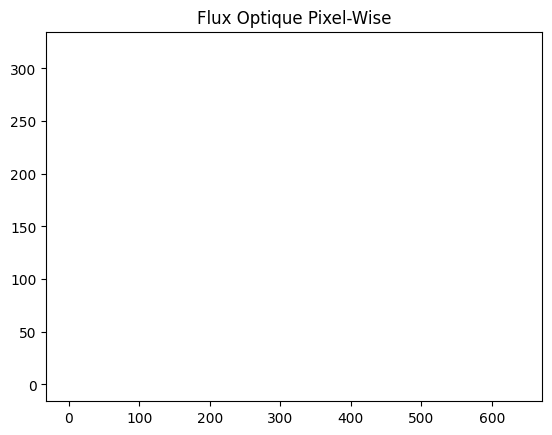

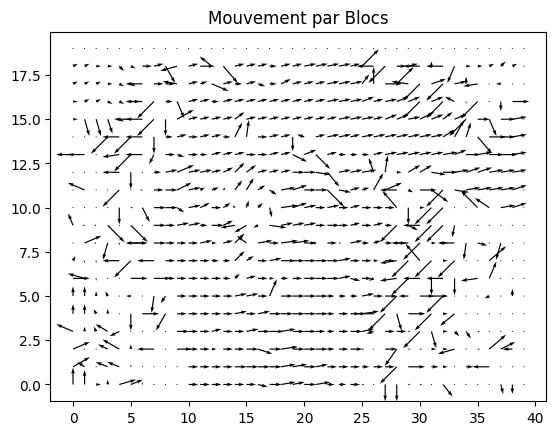

In [11]:
import matplotlib.pyplot as plt

# Visualiser le flot optique
plt.quiver(flow[..., 0], flow[..., 1])
plt.title("Flux Optique Pixel-Wise")
plt.show()

# Visualiser le mouvement par blocs
plt.quiver(block_flow[..., 0], block_flow[..., 1])
plt.title("Mouvement par Blocs")
plt.show()


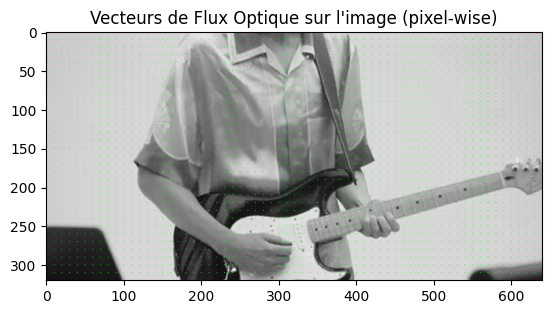

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_optical_flow(image, flow, step=10):
    """
    Dessine les vecteurs de flux optique sur l'image.
    
    Args:
        image: Image sur laquelle dessiner les vecteurs.
        flow: Vecteurs de flux optique (matrice de vecteurs).
        step: Intervalle entre les vecteurs à dessiner pour réduire l'affichage.
    """
    img_with_flow = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    h, w = image.shape
    for i in range(0, h, step):
        for j in range(0, w, step):
            # Vecteurs de déplacement
            dx, dy = flow[i, j]
            end_point = (int(j + dx), int(i + dy))
            cv2.arrowedLine(img_with_flow, (j, i), end_point, (0, 255, 0), 1, tipLength=0.3)
    
    return img_with_flow

# Appliquer la fonction pour tracer les vecteurs du flux optique
flow_image = draw_optical_flow(F1, flow)

# Afficher l'image avec les vecteurs
plt.imshow(flow_image)
plt.title("Vecteurs de Flux Optique sur l'image (pixel-wise)")
plt.show()
